In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.10.0


## Load the data

In [3]:
df = pd.read_csv('../cleaned_data/EXCL.csv', index_col='Date', parse_dates=True)
df.head()

7 DAYS MA  7 DAYS STD DEV  14 DAYS MA  21 DAYS MA  dayofweek  \
Date                                                                       
2012-10-17   3.059533        1.053684    3.007273    2.938809   0.008923   
2012-10-18   3.111350        1.915311    3.046031    2.964583   0.716706   
2012-10-19   3.176120        1.970523    3.081559    2.988210   1.424489   
2012-10-22   3.253845        1.767559    3.120318    3.016132  -1.406643   
2012-10-23   3.299184        0.647818    3.149386    3.035463  -0.698860   

            quarter     month      year  dayofyear  dayofmonth  weekofyear  \
Date                                                                         
2012-10-17  1.34241  1.016593 -1.845348   1.033444    0.147246    1.030312   
2012-10-18  1.34241  1.016593 -1.845348   1.042927    0.261864    1.030312   
2012-10-19  1.34241  1.016593 -1.845348   1.052410    0.376483    1.030312   
2012-10-22  1.34241  1.016593 -1.845348   1.080859    0.720337    1.096678   
2012-10-23  1.34241  1.016593 -1.845348   1.090342    0.834955    1.096678   

               Close  
Date                  
2012-10-17  3.395286  
2012-10-18  3.395286  
2012-10-19  3.486288  
2012-10-22  3.304284  
2012-10-23  3.213282

### Plot the Close price - our target

Text(0.5, 1.0, 'EXCL.JK Close Price')

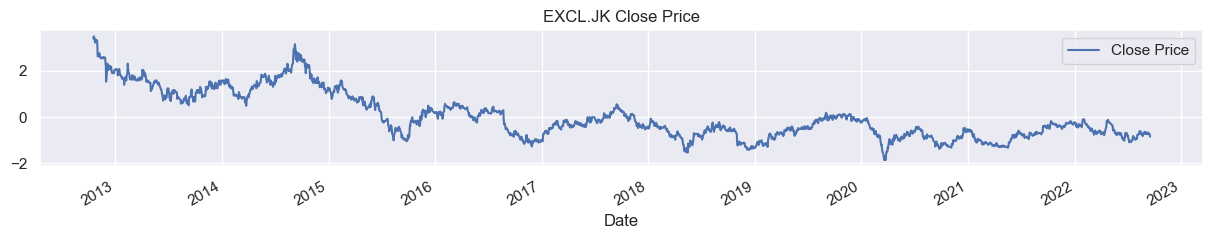

In [4]:
df['Close'].plot(figsize=(15,2))
plt.legend(['Close Price'])
plt.title('EXCL.JK Close Price')

### Split the data
- Split the data into independent variables and target variable
- Split the data into train and test set (80:20)

In [5]:
train_len = int(len(df)*.8)
train_dataset = df[:train_len]
test_dataset = df[train_len:len(df)]

In [6]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Close')
test_labels = test_features.pop('Close')

## Understanding Time Series Data

### Decompose time series into Trend, Seasonality, and Random Noise

In [7]:
import statsmodels.api as sm

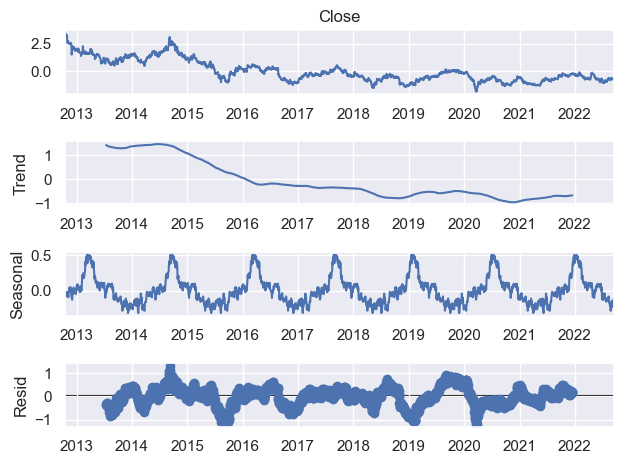

In [8]:
seas_d = sm.tsa.seasonal_decompose(df['Close'], model='additive', period=365)
fig = seas_d.plot()
plt.show()

### ADF Test to check stationarity of the data

In [9]:
from statsmodels.tsa.stattools import adfuller
def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)

In [10]:
test_adf(df['Close'], 'Stock Close Price')

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary Stock Close Price


In [11]:
"""
The Close price is not stationary. 
Therefore, differencing needs to be performed
"""
test_adf(df['Close'].diff(), 'Stock Close Price - First Difference')

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary Stock Close Price - First Difference


### Plot ACF (Autocorrelation) and PACF (Partial Autocorrelation)

C:\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


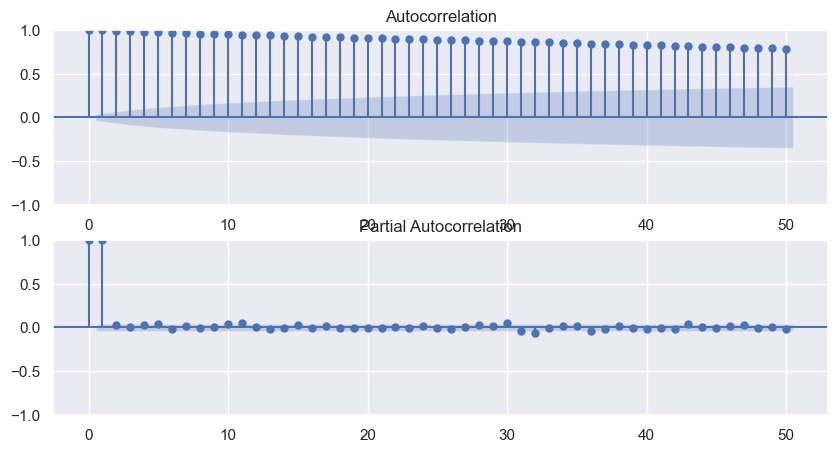

In [12]:
fig, ax = plt.subplots(2,1, figsize=(10,5))

fig = sm.tsa.graphics.plot_acf(df['Close'], lags=50, ax=ax[0])

fig = sm.tsa.graphics.plot_pacf(df['Close'], lags=50, ax=ax[1])
plt.show()

## Build the SARIMAX model

### Use auto_arima to determine the optimal p,d,q orders
We can determine p,d,q orders by using ACF and PACF plots above. However, a stepwise search will enable us to try out more optimal p,d,q orders.

In [13]:
from pmdarima.arima import auto_arima

In [14]:
step_wise_exog = auto_arima(train_labels, exogenous= train_features,
                           start_p=1, start_q=1, 
                           max_p=7, max_q=7, 
                           d=None, D=1, test='adf', max_d=7, seasonal=True, m=5,
                           trace=True, 
                           error_action='ignore', 
                           suppress_warnings=True,
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[5] intercept   : AIC=inf, Time=1.91 sec
 ARIMA(0,0,0)(0,1,0)[5] intercept   : AIC=-960.171, Time=0.13 sec
 ARIMA(1,0,0)(1,1,0)[5] intercept   : AIC=-3193.443, Time=0.75 sec
 ARIMA(0,0,1)(0,1,1)[5] intercept   : AIC=-2162.269, Time=0.58 sec
 ARIMA(0,0,0)(0,1,0)[5]             : AIC=-955.211, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[5] intercept   : AIC=-2715.507, Time=0.10 sec
 ARIMA(1,0,0)(2,1,0)[5] intercept   : AIC=-3401.444, Time=1.62 sec
 ARIMA(1,0,0)(2,1,1)[5] intercept   : AIC=inf, Time=3.70 sec
 ARIMA(1,0,0)(1,1,1)[5] intercept   : AIC=inf, Time=1.82 sec
 ARIMA(0,0,0)(2,1,0)[5] intercept   : AIC=-973.604, Time=0.72 sec
 ARIMA(2,0,0)(2,1,0)[5] intercept   : AIC=-3401.509, Time=2.35 sec
 ARIMA(2,0,0)(1,1,0)[5] intercept   : AIC=-3195.920, Time=0.90 sec
 ARIMA(2,0,0)(2,1,1)[5] intercept   : AIC=inf, Time=4.42 sec
 ARIMA(2,0,0)(1,1,1)[5] intercept   : AIC=inf, Time=2.02 sec
 ARIMA(3,0,0)(2,1,0)[5] intercept   : AIC=-3401.620,

In [15]:
step_wise_exog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1967
Model:             SARIMAX(3, 0, 0)x(2, 1, 0, 5)   Log Likelihood                1707.056
Date:                           Mon, 21 Nov 2022   AIC                          -3402.113
Time:                                   16:28:47   BIC                          -3368.623
Sample:                                        0   HQIC                         -3389.804
                                          - 1967                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9178      0.017     54.708      0.000       0.885       0.951
ar.L2         -0.0027      0.023     -0.118      0.906      -0.048       0.043
ar.L3         -0.0323      0.018     -1.795      0.073      -0.068       0.003
ar.S.L5       -0.6457      0.020    -31.972      0.000      -0.685      -0.606
ar.S.L10      -0.3261      0.020    -16.452      0.000      -0.365      -0.287
sigma2         0.0103      0.000     48.759      0.000       0.010       0.011
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               772.41
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

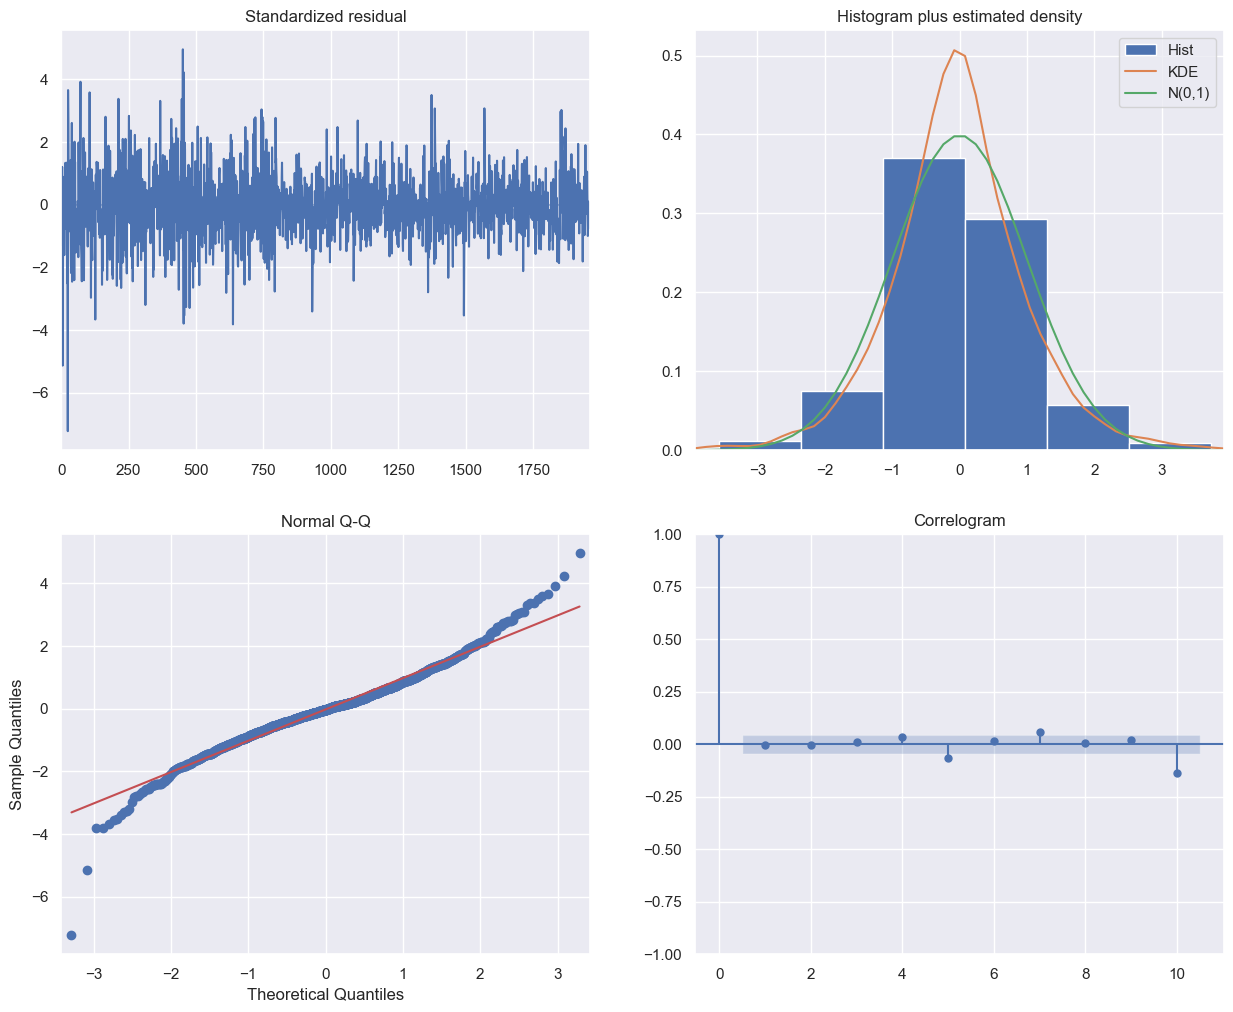

In [16]:
step_wise_exog.plot_diagnostics(figsize=(15,12));

In [17]:
raise ValueError('err')

ValueError: err

### Fit the SARIMAX model using the best p,d,q orders

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [19]:
model_exog = SARIMAX(train_labels, exog=train_features,
                order=(3,0,0), seasonal_order=(2,1,0,5),
                enforce_invertibility=True, enforce_stationarity=True)

C:\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [20]:
results = model_exog.fit()

C:\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [21]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Close   No. Observations:                 1967
Model:             SARIMAX(3, 0, 0)x(2, 1, 0, 5)   Log Likelihood                1711.262
Date:                           Mon, 21 Nov 2022   AIC                          -3388.523
Time:                                   16:29:37   BIC                          -3293.634
Sample:                                        0   HQIC                         -3353.648
                                          - 1967                                         
Covariance Type:                             opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
7 DAYS MA          0.5253      0.150      3.508      0.000       0.232       0.819
7 DAYS STD DEV     0.0061      0.004      1.684      0.092      -0.001       0.013
14 DAYS MA        -0.2339      0.157     -1.494      0.135      -0.541       0.073
21 DAYS MA         0.0447      0.143      0.313      0.754      -0.235       0.324
dayofweek          0.0003      0.002      0.110      0.913      -0.005       0.005
quarter            0.0143      0.028      0.517      0.605      -0.040       0.068
month             -2.2675      1.355     -1.673      0.094      -4.924       0.389
year              -1.0015      0.798     -1.254      0.210      -2.566       0.563
dayofyear          2.1631      1.348      1.605      0.108      -0.478       4.804
dayofmonth        -0.1823      0.111     -1.635      0.102      -0.401       0.036
weekofyear        -0.0129      0.014     -0.901      0.367      -0.041       0.015
ar.L1              0.8468      0.024     34.759      0.000       0.799       0.895
ar.L2             -0.0165      0.024     -0.694      0.488      -0.063       0.030
ar.L3             -0.0368      0.024     -1.512      0.130      -0.084       0.011
ar.S.L5           -0.6729      0.021    -31.444      0.000      -0.715      -0.631
ar.S.L10          -0.3214      0.021    -15.486      0.000      -0.362      -0.281
sigma2             0.0102      0.000     48.124      0.000       0.010       0.011
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               816.80
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Predictions

In [22]:
predictions = results.predict(start=train_len, end=len(df)-1, exog=test_features)

C:\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [23]:
actual_close = df[['Close']]
act = pd.DataFrame(actual_close.iloc[train_len:, 0])

In [24]:
predictions = pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index = test_features.index
predictions['Actual'] = act['Close']
predictions.rename(columns={'predicted_mean':'Pred'}, inplace=True)

In [25]:
predictions

Pred    Actual
Date                          
2020-09-10 -1.138849 -1.274796
2020-09-11 -1.122769 -1.136410
2020-09-14 -1.162210 -1.062604
2020-09-15 -1.145592 -1.127184
2020-09-16 -1.123316 -1.191764
...              ...       ...
2022-09-12 -1.734008 -0.721252
2022-09-13 -1.722199 -0.712026
2022-09-14 -1.714490 -0.767380
2022-09-15 -1.722266 -0.776606
2022-09-16 -1.706372 -0.850412

[492 rows x 2 columns]

<AxesSubplot: xlabel='Date'>

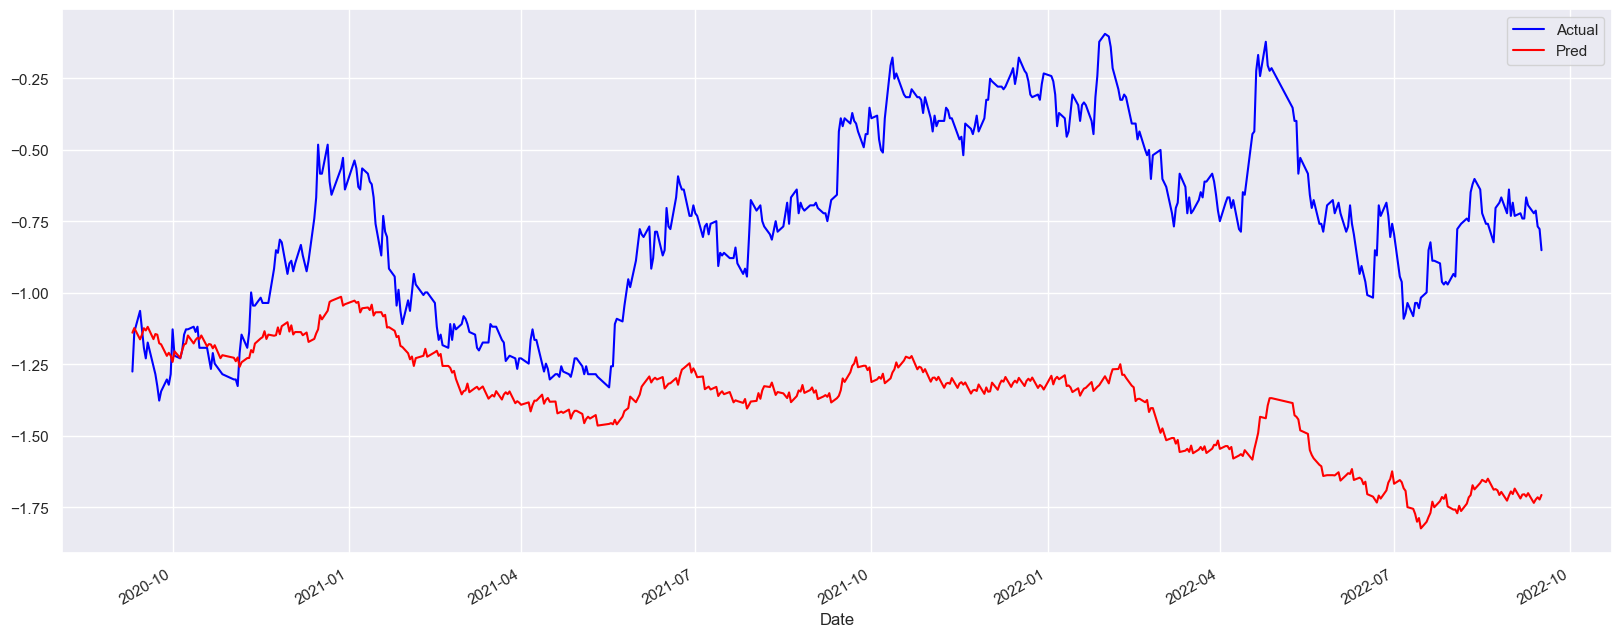

In [26]:
predictions['Actual'].plot(figsize=(20,8), legend=True, color='blue')
predictions['Pred'].plot(legend=True, color='red', figsize=(20,8))

### Evaluation

In [27]:
from joblib import load

In [28]:
close_scaler = load('../feature_engineering/excl_close_scaler.bin')

In [29]:
inversed_pred = close_scaler.inverse_transform(np.array(predictions['Pred']).reshape(-1,1))
inversed_act = close_scaler.inverse_transform(np.array(predictions['Actual']).reshape(-1,1))

In [30]:
inversed = pd.DataFrame(inversed_pred)
inversed['Actual'] = inversed_act
inversed.rename({0:'Pred'}, axis=1, inplace=True)
inversed.index = test_labels.index
inversed.head(2)

Pred  Actual
Date                           
2020-09-10  2187.356362  2040.0
2020-09-11  2204.785519  2190.0

**Plot Error Distribution**

In [31]:
def plotErrorHist(inversed_df):
    """
    Function to plot error histogram
    """
    error = inversed_df['Pred'] - inversed_df['Actual']
    plt.hist(error, bins=25)
    plt.xlabel('Prediction Error [Close]')
    _ = plt.ylabel('Count')

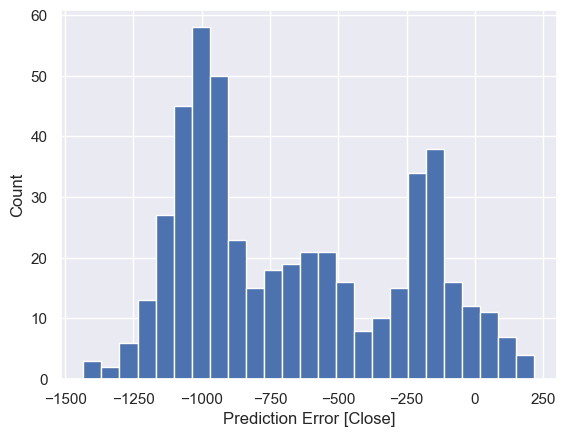

In [32]:
plotErrorHist(inversed)

**RMSE**

In [33]:
from statsmodels.tools.eval_measures import rmse

In [34]:
rmse(inversed['Pred'], inversed['Actual'])

776.4040359145281

**MAPE**

In [35]:
# mape
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [36]:
mape(inversed['Actual'], inversed['Pred'])

24.630910275151244

**R-squared**

In [37]:
from sklearn.metrics import r2_score

In [38]:
r2_score(inversed['Actual'], inversed['Pred'])

-3.9997948904403087

### Save the model

In [39]:
from joblib import dump, load
dump(results, './models/excl.joblib') 

['./models/excl.joblib']

In [40]:
loaded = load('./models/excl.joblib')
loaded.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Close   No. Observations:                 1967
Model:             SARIMAX(3, 0, 0)x(2, 1, 0, 5)   Log Likelihood                1711.262
Date:                           Mon, 21 Nov 2022   AIC                          -3388.523
Time:                                   16:30:23   BIC                          -3293.634
Sample:                                        0   HQIC                         -3353.648
                                          - 1967                                         
Covariance Type:                             opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
7 DAYS MA          0.5253      0.150      3.508      0.000       0.232       0.819
7 DAYS STD DEV     0.0061      0.004      1.684      0.092      -0.001       0.013
14 DAYS MA        -0.2339      0.157     -1.494      0.135      -0.541       0.073
21 DAYS MA         0.0447      0.143      0.313      0.754      -0.235       0.324
dayofweek          0.0003      0.002      0.110      0.913      -0.005       0.005
quarter            0.0143      0.028      0.517      0.605      -0.040       0.068
month             -2.2675      1.355     -1.673      0.094      -4.924       0.389
year              -1.0015      0.798     -1.254      0.210      -2.566       0.563
dayofyear          2.1631      1.348      1.605      0.108      -0.478       4.804
dayofmonth        -0.1823      0.111     -1.635      0.102      -0.401       0.036
weekofyear        -0.0129      0.014     -0.901      0.367      -0.041       0.015
ar.L1              0.8468      0.024     34.759      0.000       0.799       0.895
ar.L2             -0.0165      0.024     -0.694      0.488      -0.063       0.030
ar.L3             -0.0368      0.024     -1.512      0.130      -0.084       0.011
ar.S.L5           -0.6729      0.021    -31.444      0.000      -0.715      -0.631
ar.S.L10          -0.3214      0.021    -15.486      0.000      -0.362      -0.281
sigma2             0.0102      0.000     48.124      0.000       0.010       0.011
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               816.80
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""